# Использование бустинга в DMF

In [99]:
import numpy as np
from copy import copy
import pandas as pd
from tqdm.auto import tqdm

from scipy.integrate import quad
from scipy.stats import genextreme

from statsmodels.discrete.discrete_model import MNLogit
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from statsmodels.regression.linear_model import OLS
from sklearn.neighbors import KNeighborsRegressor

from catboost import CatBoostClassifier

from sklearn.model_selection import cross_validate, LeaveOneOut, KFold
from sklearn.metrics import roc_auc_score, accuracy_score

from IPython.display import clear_output
import matplotlib.pyplot as plt 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 8

import warnings
warnings.filterwarnings('ignore')

## Подготовка

In [2]:
beta_spend = np.array([1, 0.1, 0.0001, 1])
betas = np.array([[0.1, 0.000025, 0.3, 0.01],
                  [0.2, 0.000015, 0.2, 0.015],
                  [3, -0.00002, 0.5, -0.02]])

In [3]:
def generate_sample(n, betas=betas, beta_spend=beta_spend, verbose=False):
    
    ### Регрессоры
    x0 = np.ones(shape=n)
    x1 = np.exp(np.random.normal(loc=10, scale=0.7, size=n))
    x2 = np.random.poisson(lam=3, size=n)
    x2[x2 > 5] = 5
    x3 = np.round(np.random.uniform(low=20, high=100, size=n))
    x4 = np.random.poisson(lam=3, size=n)
    x4[x4 > 5] = 5
    df = pd.DataFrame(zip(x0, x1, x2, x3, x4),
                      columns=['const', 'income', 'health', 'age', 'drive'])
    
    ### Линейные индексы
    eps = genextreme.rvs(c=0, size=(n, 3))
    y_li = df[['const', 'income', 'health', 'age']] @ betas.T
    df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']] = y_li + eps
    df['transport'] = np.argmax(np.array(df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']]), axis=1)

    if verbose:
        print(df.transport.value_counts())
    
    ### Расходы
    rho = np.array([0.64, -0.25, 0.14])
    mevd, __ = quad(lambda x: genextreme.pdf(x, c=0) * x, -100, 100)
    m2evd, __ = quad(lambda x: genextreme.pdf(x, c=0) * x ** 2, -100, 100)
    vevd = m2evd - mevd ** 2
    vevd_rho = np.sum(vevd * rho ** 2)
    adj = np.sqrt(6) / np.pi
    sigma = 4
    
    eps_spend = sigma * adj * (eps - mevd) @ rho + \
                np.random.normal(size=n, loc=0, scale=np.sqrt(sigma ** 2 - (sigma * adj * np.sqrt(vevd_rho) ** 2)))

    spend_li = df[['const', 'age', 'income', 'drive']] @ beta_spend.T
    df['spend'] = spend_li + eps_spend
    
    df.loc[df['transport'] != 0, 'spend'] = np.nan
    
    return df

In [4]:
np.random.seed(4)

df = generate_sample(1000, verbose=True)
df.head()

2    481
0    289
1    230
Name: transport, dtype: int64


,const,income,health,age,drive,y_star_Car,y_star_Taxi,y_star_Public,transport,spend
0,1.0,22820.013044,3,32.0,4,4.662237,2.942691,6.678108,2,NaN
1,1.0,31255.978012,3,45.0,0,2.116802,5.361839,2.351739,1,NaN
2,1.0,10969.387836,5,68.0,3,2.718885,2.887521,3.999501,2,NaN
3,1.0,35793.405654,2,21.0,5,2.158243,2.879407,4.122440,2,NaN
4,1.0,16435.336097,3,51.0,3,2.464228,1.464279,3.759046,2,NaN


In [5]:
X, y = df[['const', 'income', 'health', 'age']], df['transport']
all_coefs = []
        
## Обычная линейная регрессия
df_no_nans = df.dropna()
X_spend = df_no_nans[['age', 'income', 'drive']]
y_spend = df_no_nans['spend']
lm = LinearRegression().fit(X_spend, y_spend)
all_coefs.append(['МНК', lm.intercept_] + list(lm.coef_))

In [6]:
# # LogReg sklearn
# lr = LogisticRegression(penalty='none', fit_intercept=False, multi_class='multinomial').fit(X, y)
# prob = lr.predict_proba(X)

# MNLogit statsmodels
lr = MNLogit(y, X).fit(method='newton', maxiter=10000)
prob = lr.predict()

## Лямбды
df['lambda1'] = -np.log(prob[:, 0])
df['lambda2'] = prob[:, 1] * np.log(prob[:, 1]) / (1 - prob[:, 1])
df['lambda3'] = prob[:, 2] * np.log(prob[:, 2]) / (1 - prob[:, 2])

df_no_nans = df.dropna()
X_spend = df_no_nans[['age', 'income', 'drive']]
y_spend = df_no_nans['spend']

## Линейная модель
dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                         'lambda1', 'lambda2', 'lambda3']], y_spend)
all_coefs.append(['Дурбин-МакФадден', dmf.intercept_] + list(dmf.coef_[:3]))

Optimization terminated successfully.
         Current function value: 0.935559
         Iterations 6


In [7]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              transport   No. Observations:                 1000
Model:                        MNLogit   Df Residuals:                      992
Method:                           MLE   Df Model:                            6
Date:                Wed, 25 Jan 2023   Pseudo R-squ.:                  0.1080
Time:                        22:35:42   Log-Likelihood:                -935.56
converged:                       True   LL-Null:                       -1048.8
Covariance Type:            nonrobust   LLR p-value:                 4.280e-46
===============================================================================
transport=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1151      0.343     -0.336      0.737      -0.786       0.556
income       -5.01e-06   3.68e-06     -1.361      0.173   -1.22e-05     2.2e-06
health         -0.1007      0.062     -1.629      0.103      -0.222       0.020
age             0.0049      0.004      1.244      0.214      -0.003       0.013
-------------------------------------------------------------------------------
transport=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.5704      0.306      8.402      0.000       1.971       3.170
income      -4.657e-05   5.05e-06     -9.224      0.000   -5.65e-05   -3.67e-05
health          0.2171      0.056      3.843      0.000       0.106       0.328
age            -0.0240      0.004     -6.734      0.000      -0.031      -0.017
===============================================================================
"""

In [8]:
OLS(y_spend, df_no_nans[['age', 'income', 'drive', 
                         'lambda1', 'lambda2', 'lambda3']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  spend   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                              581.0
Date:                Wed, 25 Jan 2023   Prob (F-statistic):                   6.78e-156
Time:                        22:35:42   Log-Likelihood:                         -849.87
No. Observations:                 289   AIC:                                      1712.
Df Residuals:                     283   BIC:                                      1734.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0888      0.018      4.852      0.000       0.053       0.125
income         0.0001   1.43e-05      7.664      0.000    8.13e-05       0.000
drive          0.6963      0.186      3.747      0.000       0.330       1.062
lambda1        1.9490      1.709      1.140      0.255      -1.415       5.313
lambda2       -2.5573      3.417     -0.748      0.455      -9.284       4.169
lambda3       -1.2380      3.266     -0.379      0.705      -7.666       5.190
==============================================================================
Omnibus:                        4.023   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                4.917
Skew:                          -0.056   Prob(JB):                       0.0856
Kurtosis:                       3.629   Cond. No.                     6.02e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
all_coefs = []
all_coefs.append(['Истина', 1, 0.1, 0.0001, 1])
all_coefs.append(['МНК', lm.intercept_] + list(lm.coef_))
all_coefs.append(['Дурбин-МакФадден', dmf.intercept_] + list(dmf.coef_[:3]))

pd.DataFrame(all_coefs, columns=['method', 'const', 'b1', 'b2', 'b3'])

,method,const,b1,b2,b3
0,Истина,1.000000,0.100000,0.000100,1.000000
1,МНК,5.954993,0.076271,0.000080,0.705369
2,Дурбин-МакФадден,15.397569,0.077156,0.000051,0.692962


## Основная часть

In [10]:
def simulate(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    lr_metrics = []
    boost_metrics = []
    ml_coefs = []

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        pred_lr = np.argmax(prob_lr, axis=1)
        scores_lr = [roc_auc_score(y, prob_lr, multi_class='ovo'),
                  roc_auc_score(y, prob_lr, multi_class='ovr'),
                  accuracy_score(y, pred_lr)]
        lr_metrics.append(scores_lr)
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        pred_boost = boosting.predict(X)
        scores_boost = [roc_auc_score(y, prob_boost, multi_class='ovo'),
                  roc_auc_score(y, prob_boost, multi_class='ovr'),
                  accuracy_score(y, pred_boost)]
        boost_metrics.append(scores_boost)
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_boost[:, 0])
        df['lambda2'] = prob_boost[:, 1] * np.log(prob_boost[:, 1]) / (1 - prob_boost[:, 1])
        df['lambda3'] = prob_boost[:, 2] * np.log(prob_boost[:, 2]) / (1 - prob_boost[:, 2])
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
    
        ## Линейная модель
        dmf_ml = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
    return ols_coefs, dmf_coefs, ml_coefs, lr_metrics, boost_metrics
        

In [11]:
def calc_coef_metrics(ests, true, model_name):
    return [model_name] + list(np.sqrt(np.mean((np.array(ests) - true) ** 2, axis=0))) + \
           list(100 * np.mean(np.abs(np.array(ests) - true) / true, axis=0))

def calc_class_metrics(scores, model_name):
    return [model_name] + list(np.mean(scores, axis=0))


## Симуляции 1. 
### Для оценки вероятностей вместо логита используется ненастроенный бустинг

### Выборка размером 1 000

In [12]:
np.random.seed(3)

n_simulations = 1000
n_size = 1000

ols_coefs, dmf_coefs, ml_coefs, lr_metrics, boost_metrics = simulate(n_simulations, n_size)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
cols_names = ['METHOD', 'RMSE0', 'RMSE1', 'RMSE2', 'RMSE3', 'MAPE0', 'MAPE1', 'MAPE2', 'MAPE3']

results = [calc_coef_metrics(ols_coefs, beta_spend, model_name='OLS'),
           calc_coef_metrics(dmf_coefs, beta_spend, model_name='DMF'),
           calc_coef_metrics(ml_coefs, beta_spend, model_name='ML+DMF')]

pd.DataFrame(results, columns=cols_names)

,METHOD,RMSE0,RMSE1,RMSE2,RMSE3,MAPE0,MAPE1,MAPE2,MAPE3
0,OLS,4.255701,0.018595,0.000024,0.181157,410.435304,15.327993,21.846520,14.478837
1,DMF,19.748012,0.032322,0.000078,0.181414,1400.651917,23.974590,55.798315,14.502202
2,ML+DMF,6.422239,0.019950,0.000023,0.182008,522.672210,16.047768,18.801809,14.513702


In [14]:
cols_names2 = ['METHOD', 'ROC-AUC-OVO', 'ROC-AUC-OVR', 'ACCURACY']

class_metrics = [calc_class_metrics(lr_metrics, 'LogReg'),
                 calc_class_metrics(boost_metrics, 'Boosting')]


pd.DataFrame(class_metrics, columns=cols_names2)

,METHOD,ROC-AUC-OVO,ROC-AUC-OVR,ACCURACY
0,LogReg,0.688006,0.707715,0.554841
1,Boosting,0.710701,0.728111,0.573692


Как можно увидеть, при размере выборки в 1000 классический подход Дурбина-МакФаддена сильно проигрывает как обычному МНК, так и бустингу. Возможно, при DMF в на каких-то итерациях возникали слишком большие ошибки при оценивании коэффициентов, из-за чего метрики (в среднем) увеличились. 

Такой просадок подхода DMF можно объяснить плохим качеством работы многомерного логита: по сравнению даже с ненастроенным бустингом на 10 деревьях глубиной 3 многомерный логит достаточно сильно проигрывает как по двум AUC-ROC, так и по Accuracy.

Качество оценки коэффициентов бустинга на тысяче наблюдений приблизительно совпадает с результатами обычного МНК: по каким-то коэффициентам качество немного лучше, по каким-то $-$ немного хуже. Но здесь стоит отметить, что мы использовали ненастроенный бустинг. Возможно, результат можно было улучшить, если бы мы подобрали оптимальные гиперпараметры.

### Выборка размером 10 000

In [15]:
np.random.seed(666)

n_simulations = 1000
n_size = 10000

ols_coefs, dmf_coefs, ml_coefs, lr_metrics, boost_metrics = simulate(n_simulations, n_size)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
cols_names1 = ['METHOD', 'RMSE0', 'RMSE1', 'RMSE2', 'RMSE3', 'MAPE0', 'MAPE1', 'MAPE2', 'MAPE3']

results = [calc_coef_metrics(ols_coefs, beta_spend, model_name='OLS'),
           calc_coef_metrics(dmf_coefs, beta_spend, model_name='DMF'),
           calc_coef_metrics(ml_coefs, beta_spend, model_name='ML+DMF')]

pd.DataFrame(results, columns=cols_names1)

,METHOD,RMSE0,RMSE1,RMSE2,RMSE3,MAPE0,MAPE1,MAPE2,MAPE3
0,OLS,4.119811,0.014189,0.000022,0.056260,410.557609,13.675868,21.714867,4.518778
1,DMF,4.334835,0.007113,0.000018,0.056123,338.483583,5.686931,13.645356,4.500399
2,ML+DMF,3.371943,0.007000,0.000013,0.056153,286.303851,5.554313,11.196034,4.507395


In [17]:
cols_names2 = ['METHOD', 'ROC-AUC-OVO', 'ROC-AUC-OVR', 'ACCURACY']

class_metrics = [calc_class_metrics(lr_metrics, 'LogReg'),
                 calc_class_metrics(boost_metrics, 'Boosting')]


pd.DataFrame(class_metrics, columns=cols_names2)

,METHOD,ROC-AUC-OVO,ROC-AUC-OVR,ACCURACY
0,LogReg,0.686080,0.706200,0.552309
1,Boosting,0.686585,0.705994,0.552335


Как можно увидеть, при размере выборки в 10 000 классический DMF начинает демонстрировать себя лучше обычного МНК, практически на равных с подходом, когда вероятности предсказываются бустингом. Но по метрикам MAPE и RMSE подход с бустингом все равно немного выигрывает по почти всем коэффициентам.

Различия в рассматриваемых метриках классификации (ROC-AUC'и и Accuracy) между подходами на таком размере выборки минимальны.

## Симуляции 2.
### Вместо лямбд в регресии DMF используется полином из бустинговых вероятностей

In [18]:
def simulate2(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    ml_coefs = []
    best_ks = []
    

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
        ## Полиномы вероятностей
        # Подбираем лучший по LOO-CV (по RMSE)
        ks = np.arange(1, 7)
        all_rmses = []
        for k in ks:
            # генерируем степени вероятностей
            for i in range(1, k+1):
                df[f'proba0^{i}'] = prob_boost[:, 0] ** i
                df[f'proba1^{i}'] = prob_boost[:, 1] ** i
                df[f'proba2^{i}'] = prob_boost[:, 2] ** i
            needed_columns = ['age', 'income', 'drive'] \
                           + [f'proba{category}^{power}' for category in [0, 1, 2] 
                                                         for power in range(1, i)]
            X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
            # считаем RMSE по LOO
            mse_for_k = []
            loo = LeaveOneOut()
            for train, test in loo.split(X, y):
                X_train, y_train = X.iloc[train], y.iloc[train]
                X_test, y_test = X.iloc[test], y.iloc[test]
                
                lm = LinearRegression().fit(X_train, y_train)
                mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
            all_rmses.append(np.sqrt(np.mean(mse_for_k)))
        best_k = ks[np.argmin(all_rmses)]
        best_ks.append(best_k)
        
        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
    return ols_coefs, dmf_coefs, ml_coefs, best_ks
        

### Выборка размером 1 000

Так как процесс LOO-CV достаточно длителен, здесь и в подобных пунктах далее проводится всего 50 симуляций


In [19]:
np.random.seed(666)

n_simulations = 50
n_size = 1000

ols_coefs, dmf_coefs, ml_coefs, best_ks = simulate2(n_simulations, n_size)

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
cols_names = ['METHOD', 'RMSE0', 'RMSE1', 'RMSE2', 'RMSE3', 'MAPE0', 'MAPE1', 'MAPE2', 'MAPE3']

results = [calc_coef_metrics(ols_coefs, beta_spend, model_name='OLS'),
           calc_coef_metrics(dmf_coefs, beta_spend, model_name='DMF'),
           calc_coef_metrics(ml_coefs, beta_spend, model_name='ML+DMF')]

pd.DataFrame(results, columns=cols_names)

,METHOD,RMSE0,RMSE1,RMSE2,RMSE3,MAPE0,MAPE1,MAPE2,MAPE3
0,OLS,4.296189,0.020730,0.000026,0.187674,420.395139,16.602936,24.210997,14.934839
1,DMF,16.882431,0.032644,0.000075,0.190803,1197.096846,25.275022,53.149885,15.423445
2,ML+DMF,11.170387,0.023685,0.000025,0.191261,610.721091,18.071402,18.180463,15.529859


In [21]:
pd.DataFrame(best_ks, columns=['best_k']).describe()

,best_k
count,50.000000
mean,1.360000
std,0.662709
min,1.000000
25%,1.000000
50%,1.000000
75%,1.750000
max,3.000000


### Выборка размером 10 000

In [22]:
np.random.seed(666)

n_simulations = 50
n_size = 10000

ols_coefs, dmf_coefs, ml_coefs, best_ks = simulate2(n_simulations, n_size)

  0%|          | 0/50 [00:00<?, ?it/s]

In [23]:
cols_names1 = ['METHOD', 'RMSE0', 'RMSE1', 'RMSE2', 'RMSE3', 'MAPE0', 'MAPE1', 'MAPE2', 'MAPE3']

results = [calc_coef_metrics(ols_coefs, beta_spend, model_name='OLS'),
           calc_coef_metrics(dmf_coefs, beta_spend, model_name='DMF'),
           calc_coef_metrics(ml_coefs, beta_spend, model_name='ML+DMF')]

pd.DataFrame(results, columns=cols_names1)

,METHOD,RMSE0,RMSE1,RMSE2,RMSE3,MAPE0,MAPE1,MAPE2,MAPE3
0,OLS,4.146683,0.013947,0.000023,0.051841,413.145627,13.450334,22.364699,4.135324
1,DMF,4.125252,0.006212,0.000017,0.051751,346.098196,4.920815,13.846808,4.127050
2,ML+DMF,14.374681,0.007546,0.000014,0.051583,823.316366,5.974775,12.826419,4.098673


In [24]:
pd.DataFrame(best_ks, columns=['best_k']).describe()

,best_k
count,50.000000
mean,2.600000
std,0.728431
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,4.000000


## Симуляции 3.
### Ошибки распределены не по Гумбелю

### а) Многомерное нормальное

In [25]:
mu = np.array([0, 0, 0, 0])

cov = np.array([[1   , 0.5 , -0.2, 0.1 ],
                [0.5 , 1   , 0.25, -0.1],
                [-0.2, 0.25, 1   , 0.7 ],
                [0.1 , -0.1, 0.7 , 1   ]])

np.random.multivariate_normal(mean=mu, cov=cov, size=1000)

array([[ 1.67779357,  0.58432698,  0.4930397 ,  1.05142317],
       [-0.95085771, -1.23793308, -0.60837145, -0.28485006],
       [-0.571355  , -1.27831472,  0.10937215,  0.56641909],
       ...,
       [ 0.64019912,  0.86012823,  0.32258154,  0.52452309],
       [-0.43503032, -0.39294654, -0.63291338,  0.00507544],
       [ 1.34349398, -0.16395317, -0.7027106 ,  0.03444963]])

In [26]:
def generate_sample2(n, betas=betas, beta_spend=beta_spend, verbose=False):
    
    ### Регрессоры
    x0 = np.ones(shape=n)
    x1 = np.exp(np.random.normal(loc=10, scale=0.7, size=n))
    x2 = np.random.poisson(lam=3, size=n)
    x2[x2 > 5] = 5
    x3 = np.round(np.random.uniform(low=20, high=100, size=n))
    x4 = np.random.poisson(lam=3, size=n)
    x4[x4 > 5] = 5
    df = pd.DataFrame(zip(x0, x1, x2, x3, x4),
                      columns=['const', 'income', 'health', 'age', 'drive'])
    
    ### Линейные индексы
    all_eps = np.random.multivariate_normal(mean=mu, cov=cov, size=n)
    eps = all_eps[:, :3]
    eps_spend = all_eps[:, 3]
    y_li = df[['const', 'income', 'health', 'age']] @ betas.T
    df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']] = y_li + eps
    df['transport'] = np.argmax(np.array(df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']]), axis=1)

    if verbose:
        print(df.transport.value_counts())
    
    ### Расходы
    spend_li = df[['const', 'age', 'income', 'drive']] @ beta_spend.T
    df['spend'] = spend_li + eps_spend
    
    df.loc[df['transport'] != 0, 'spend'] = np.nan
    
    return df

### Если использовать в лямбдах оценки вероятностей бустинга

In [27]:
def simulate3(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    lr_metrics = []
    boost_metrics = []
    ml_coefs = []

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample2(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        pred_lr = np.argmax(prob_lr, axis=1)
        scores_lr = [roc_auc_score(y, prob_lr, multi_class='ovo'),
                  roc_auc_score(y, prob_lr, multi_class='ovr'),
                  accuracy_score(y, pred_lr)]
        lr_metrics.append(scores_lr)
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        pred_boost = boosting.predict(X)
        scores_boost = [roc_auc_score(y, prob_boost, multi_class='ovo'),
                  roc_auc_score(y, prob_boost, multi_class='ovr'),
                  accuracy_score(y, pred_boost)]
        boost_metrics.append(scores_boost)
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_boost[:, 0])
        df['lambda2'] = prob_boost[:, 1] * np.log(prob_boost[:, 1]) / (1 - prob_boost[:, 1])
        df['lambda3'] = prob_boost[:, 2] * np.log(prob_boost[:, 2]) / (1 - prob_boost[:, 2])
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
    
        ## Линейная модель
        dmf_ml = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
    return ols_coefs, dmf_coefs, ml_coefs, lr_metrics, boost_metrics
        

### Выборка размером 1 000

In [28]:
np.random.seed(3)

n_simulations = 1000
n_size = 1000

ols_coefs, dmf_coefs, ml_coefs, lr_metrics, boost_metrics = simulate3(n_simulations, n_size)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
cols_names = ['METHOD', 'RMSE0', 'RMSE1', 'RMSE2', 'RMSE3', 'MAPE0', 'MAPE1', 'MAPE2', 'MAPE3']

results = [calc_coef_metrics(ols_coefs, beta_spend, model_name='OLS'),
           calc_coef_metrics(dmf_coefs, beta_spend, model_name='DMF'),
           calc_coef_metrics(ml_coefs, beta_spend, model_name='ML+DMF')]

pd.DataFrame(results, columns=cols_names)

,METHOD,RMSE0,RMSE1,RMSE2,RMSE3,MAPE0,MAPE1,MAPE2,MAPE3
0,OLS,0.705050,0.006231,0.000004,0.036998,67.035839,5.731948,3.665282,2.988687
1,DMF,1.677574,0.004812,0.000009,0.037211,128.855280,3.846853,6.922438,3.014501
2,ML+DMF,0.908901,0.004132,0.000004,0.037287,71.183593,3.288857,3.005621,3.021048


In [30]:
cols_names2 = ['METHOD', 'ROC-AUC-OVO', 'ROC-AUC-OVR', 'ACCURACY']

class_metrics = [calc_class_metrics(lr_metrics, 'LogReg'),
                 calc_class_metrics(boost_metrics, 'Boosting')]


pd.DataFrame(class_metrics, columns=cols_names2)

,METHOD,ROC-AUC-OVO,ROC-AUC-OVR,ACCURACY
0,LogReg,0.733646,0.762218,0.628691
1,Boosting,0.750687,0.776637,0.642059


### Выборка размером 10 000

In [31]:
np.random.seed(3)

n_simulations = 1000
n_size = 10000

ols_coefs, dmf_coefs, ml_coefs, lr_metrics, boost_metrics = simulate3(n_simulations, n_size)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
cols_names = ['METHOD', 'RMSE0', 'RMSE1', 'RMSE2', 'RMSE3', 'MAPE0', 'MAPE1', 'MAPE2', 'MAPE3']

results = [calc_coef_metrics(ols_coefs, beta_spend, model_name='OLS'),
           calc_coef_metrics(dmf_coefs, beta_spend, model_name='DMF'),
           calc_coef_metrics(ml_coefs, beta_spend, model_name='ML+DMF')]

pd.DataFrame(results, columns=cols_names)

,METHOD,RMSE0,RMSE1,RMSE2,RMSE3,MAPE0,MAPE1,MAPE2,MAPE3
0,OLS,0.673357,0.005822,0.000004,0.011343,66.982691,5.773410,3.525952,0.917152
1,DMF,0.466160,0.001250,0.000002,0.011291,36.743544,1.002820,1.838856,0.913035
2,ML+DMF,0.429883,0.001344,0.000002,0.011297,35.121113,1.082643,1.381514,0.912323


In [33]:
cols_names2 = ['METHOD', 'ROC-AUC-OVO', 'ROC-AUC-OVR', 'ACCURACY']

class_metrics = [calc_class_metrics(lr_metrics, 'LogReg'),
                 calc_class_metrics(boost_metrics, 'Boosting')]


pd.DataFrame(class_metrics, columns=cols_names2)

,METHOD,ROC-AUC-OVO,ROC-AUC-OVR,ACCURACY
0,LogReg,0.731781,0.760513,0.626029
1,Boosting,0.730921,0.758949,0.625363


### Если использовать вместо лямбд полином из бустинговых вероятностей

In [34]:
def simulate4(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    ml_coefs = []
    best_ks = []
    

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample2(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
        ## Полиномы вероятностей
        # Подбираем лучший по LOO-CV (по RMSE)
        ks = np.arange(1, 7)
        all_rmses = []
        for k in ks:
            # генерируем степени вероятностей
            for i in range(1, k+1):
                df[f'proba0^{i}'] = prob_boost[:, 0] ** i
                df[f'proba1^{i}'] = prob_boost[:, 1] ** i
                df[f'proba2^{i}'] = prob_boost[:, 2] ** i
            needed_columns = ['age', 'income', 'drive'] \
                           + [f'proba{category}^{power}' for category in [0, 1, 2] 
                                                         for power in range(1, i)]
            X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
            # считаем RMSE по LOO
            mse_for_k = []
            loo = LeaveOneOut()
            for train, test in loo.split(X, y):
                X_train, y_train = X.iloc[train], y.iloc[train]
                X_test, y_test = X.iloc[test], y.iloc[test]
                
                lm = LinearRegression().fit(X_train, y_train)
                mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
            all_rmses.append(np.sqrt(np.mean(mse_for_k)))
        best_k = ks[np.argmin(all_rmses)]
        best_ks.append(best_k)
        
        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
    return ols_coefs, dmf_coefs, ml_coefs, best_ks
        

### Выборка размером 1 000

In [35]:
np.random.seed(3)

n_simulations = 50
n_size = 1000

ols_coefs, dmf_coefs, ml_coefs, best_ks = simulate4(n_simulations, n_size)

  0%|          | 0/50 [00:00<?, ?it/s]

In [36]:
cols_names1 = ['METHOD', 'RMSE0', 'RMSE1', 'RMSE2', 'RMSE3', 'MAPE0', 'MAPE1', 'MAPE2', 'MAPE3']

results = [calc_coef_metrics(ols_coefs, beta_spend, model_name='OLS'),
           calc_coef_metrics(dmf_coefs, beta_spend, model_name='DMF'),
           calc_coef_metrics(ml_coefs, beta_spend, model_name='ML+DMF')]

pd.DataFrame(results, columns=cols_names1)

,METHOD,RMSE0,RMSE1,RMSE2,RMSE3,MAPE0,MAPE1,MAPE2,MAPE3
0,OLS,0.746648,0.006308,0.000004,0.035417,71.371556,5.871597,4.106311,2.834120
1,DMF,1.497897,0.005298,0.000008,0.035750,121.695985,4.224368,6.613226,2.853886
2,ML+DMF,5.406533,0.004027,0.000004,0.034312,208.216839,3.275116,2.627673,2.719852


In [37]:
pd.DataFrame(best_ks, columns=['best_k']).describe()

,best_k
count,50.00000
mean,1.84000
std,1.16689
min,1.00000
25%,1.00000
50%,2.00000
75%,2.00000
max,6.00000


### Выборка размером 10 000

In [38]:
np.random.seed(3)

n_simulations = 50
n_size = 10000

ols_coefs, dmf_coefs, ml_coefs, best_ks = simulate4(n_simulations, n_size)

  0%|          | 0/50 [00:00<?, ?it/s]

In [39]:
cols_names1 = ['METHOD', 'RMSE0', 'RMSE1', 'RMSE2', 'RMSE3', 'MAPE0', 'MAPE1', 'MAPE2', 'MAPE3']

results = [calc_coef_metrics(ols_coefs, beta_spend, model_name='OLS'),
           calc_coef_metrics(dmf_coefs, beta_spend, model_name='DMF'),
           calc_coef_metrics(ml_coefs, beta_spend, model_name='ML+DMF')]

pd.DataFrame(results, columns=cols_names1)

,METHOD,RMSE0,RMSE1,RMSE2,RMSE3,MAPE0,MAPE1,MAPE2,MAPE3
0,OLS,0.680295,0.005815,0.000004,0.010455,67.693125,5.776267,3.517592,0.845574
1,DMF,0.464510,0.001137,0.000002,0.010648,36.189015,0.867160,1.817984,0.872709
2,ML+DMF,2.132491,0.001180,0.000002,0.010514,113.339672,0.948531,1.298467,0.849793


In [40]:
pd.DataFrame(best_ks, columns=['best_k']).describe()

,best_k
count,50.000000
mean,2.760000
std,0.938083
min,2.000000
25%,2.000000
50%,2.500000
75%,3.000000
max,5.000000


### б) Экспоненциальное распределение ошибок

### Если использовать в лямбдах оценки вероятностей бустинга

In [41]:
def generate_sample3(n, betas=betas, beta_spend=beta_spend, verbose=False):
    
    ### Регрессоры
    x0 = np.ones(shape=n)
    x1 = np.exp(np.random.normal(loc=10, scale=0.7, size=n))
    x2 = np.random.poisson(lam=3, size=n)
    x2[x2 > 5] = 5
    x3 = np.round(np.random.uniform(low=20, high=100, size=n))
    x4 = np.random.poisson(lam=3, size=n)
    x4[x4 > 5] = 5
    df = pd.DataFrame(zip(x0, x1, x2, x3, x4),
                      columns=['const', 'income', 'health', 'age', 'drive'])
    
    ### Линейные индексы
    all_eps = np.random.exponential(1, size=(n, 4)) - 1
    eps = all_eps[:, :3]
    eps_spend = all_eps[:, 3]
    y_li = df[['const', 'income', 'health', 'age']] @ betas.T
    df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']] = y_li + eps
    df['transport'] = np.argmax(np.array(df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']]), axis=1)

    if verbose:
        print(df.transport.value_counts())
    
    ### Расходы
    spend_li = df[['const', 'age', 'income', 'drive']] @ beta_spend.T
    df['spend'] = spend_li + eps_spend
    
    df.loc[df['transport'] != 0, 'spend'] = np.nan
    
    return df

In [42]:
def simulate5(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    lr_metrics = []
    boost_metrics = []
    ml_coefs = []

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample3(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        pred_lr = np.argmax(prob_lr, axis=1)
        scores_lr = [roc_auc_score(y, prob_lr, multi_class='ovo'),
                  roc_auc_score(y, prob_lr, multi_class='ovr'),
                  accuracy_score(y, pred_lr)]
        lr_metrics.append(scores_lr)
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        pred_boost = boosting.predict(X)
        scores_boost = [roc_auc_score(y, prob_boost, multi_class='ovo'),
                  roc_auc_score(y, prob_boost, multi_class='ovr'),
                  accuracy_score(y, pred_boost)]
        boost_metrics.append(scores_boost)
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_boost[:, 0])
        df['lambda2'] = prob_boost[:, 1] * np.log(prob_boost[:, 1]) / (1 - prob_boost[:, 1])
        df['lambda3'] = prob_boost[:, 2] * np.log(prob_boost[:, 2]) / (1 - prob_boost[:, 2])
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
    
        ## Линейная модель
        dmf_ml = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
    return ols_coefs, dmf_coefs, ml_coefs, lr_metrics, boost_metrics
        

### Выборка размером 1 000

In [43]:
np.random.seed(3)

n_simulations = 1000
n_size = 1000

ols_coefs, dmf_coefs, ml_coefs, lr_metrics, boost_metrics = simulate5(n_simulations, n_size)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [44]:
cols_names = ['METHOD', 'RMSE0', 'RMSE1', 'RMSE2', 'RMSE3', 'MAPE0', 'MAPE1', 'MAPE2', 'MAPE3']

results = [calc_coef_metrics(ols_coefs, beta_spend, model_name='OLS'),
           calc_coef_metrics(dmf_coefs, beta_spend, model_name='DMF'),
           calc_coef_metrics(ml_coefs, beta_spend, model_name='ML+DMF')]

pd.DataFrame(results, columns=cols_names)

,METHOD,RMSE0,RMSE1,RMSE2,RMSE3,MAPE0,MAPE1,MAPE2,MAPE3
0,OLS,0.247905,0.002795,0.000002,0.041378,19.932950,2.231711,1.598064,3.246151
1,DMF,2.490607,0.005289,0.000013,0.041538,179.964347,4.092515,9.375353,3.245354
2,ML+DMF,0.899838,0.004267,0.000004,0.041388,70.435849,3.384048,3.027258,3.243598


In [45]:
cols_names2 = ['METHOD', 'ROC-AUC-OVO', 'ROC-AUC-OVR', 'ACCURACY']

class_metrics = [calc_class_metrics(lr_metrics, 'LogReg'),
                 calc_class_metrics(boost_metrics, 'Boosting')]


pd.DataFrame(class_metrics, columns=cols_names2)

,METHOD,ROC-AUC-OVO,ROC-AUC-OVR,ACCURACY
0,LogReg,0.732815,0.760820,0.621989
1,Boosting,0.749352,0.774508,0.634415


### Выборка размером 10 000

In [46]:
np.random.seed(3)

n_simulations = 1000
n_size = 10000

ols_coefs, dmf_coefs, ml_coefs, lr_metrics, boost_metrics = simulate5(n_simulations, n_size)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
cols_names = ['METHOD', 'RMSE0', 'RMSE1', 'RMSE2', 'RMSE3', 'MAPE0', 'MAPE1', 'MAPE2', 'MAPE3']

results = [calc_coef_metrics(ols_coefs, beta_spend, model_name='OLS'),
           calc_coef_metrics(dmf_coefs, beta_spend, model_name='DMF'),
           calc_coef_metrics(ml_coefs, beta_spend, model_name='ML+DMF')]

pd.DataFrame(results, columns=cols_names)

,METHOD,RMSE0,RMSE1,RMSE2,RMSE3,MAPE0,MAPE1,MAPE2,MAPE3
0,OLS,0.082106,0.000893,6.340034e-07,0.013088,6.665452,0.709686,0.505912,1.039951
1,DMF,0.549934,0.001378,2.828689e-06,0.013083,43.807004,1.082109,2.247227,1.039115
2,ML+DMF,0.310212,0.001385,1.407682e-06,0.013086,24.762630,1.092668,1.119561,1.038861


In [48]:
cols_names2 = ['METHOD', 'ROC-AUC-OVO', 'ROC-AUC-OVR', 'ACCURACY']

class_metrics = [calc_class_metrics(lr_metrics, 'LogReg'),
                 calc_class_metrics(boost_metrics, 'Boosting')]


pd.DataFrame(class_metrics, columns=cols_names2)

,METHOD,ROC-AUC-OVO,ROC-AUC-OVR,ACCURACY
0,LogReg,0.730667,0.759043,0.619709
1,Boosting,0.730023,0.757459,0.618176


### Если использовать вместо лямбд полином из бустинговых вероятностей

In [49]:
def simulate6(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    ml_coefs = []
    best_ks = []
    

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample3(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
        ## Полиномы вероятностей
        # Подбираем лучший по LOO-CV (по RMSE)
        ks = np.arange(1, 7)
        all_rmses = []
        for k in ks:
            # генерируем степени вероятностей
            for i in range(1, k+1):
                df[f'proba0^{i}'] = prob_boost[:, 0] ** i
                df[f'proba1^{i}'] = prob_boost[:, 1] ** i
                df[f'proba2^{i}'] = prob_boost[:, 2] ** i
            needed_columns = ['age', 'income', 'drive'] \
                           + [f'proba{category}^{power}' for category in [0, 1, 2] 
                                                         for power in range(1, i)]
            X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
            # считаем RMSE по LOO
            mse_for_k = []
            loo = LeaveOneOut()
            for train, test in loo.split(X, y):
                X_train, y_train = X.iloc[train], y.iloc[train]
                X_test, y_test = X.iloc[test], y.iloc[test]
                
                lm = LinearRegression().fit(X_train, y_train)
                mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
            all_rmses.append(np.sqrt(np.mean(mse_for_k)))
        best_k = ks[np.argmin(all_rmses)]
        best_ks.append(best_k)
        
        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
    return ols_coefs, dmf_coefs, ml_coefs, best_ks
        

### Выборка размером 1 000

In [50]:
np.random.seed(3)

n_simulations = 50
n_size = 1000

ols_coefs, dmf_coefs, ml_coefs, best_ks = simulate6(n_simulations, n_size)

  0%|          | 0/50 [00:00<?, ?it/s]

In [51]:
cols_names = ['METHOD', 'RMSE0', 'RMSE1', 'RMSE2', 'RMSE3', 'MAPE0', 'MAPE1', 'MAPE2', 'MAPE3']

results = [calc_coef_metrics(ols_coefs, beta_spend, model_name='OLS'),
           calc_coef_metrics(dmf_coefs, beta_spend, model_name='DMF'),
           calc_coef_metrics(ml_coefs, beta_spend, model_name='ML+DMF')]

pd.DataFrame(results, columns=cols_names)

,METHOD,RMSE0,RMSE1,RMSE2,RMSE3,MAPE0,MAPE1,MAPE2,MAPE3
0,OLS,0.248336,0.002489,0.000002,0.045273,20.229158,2.098896,1.577767,3.484871
1,DMF,2.355932,0.004555,0.000013,0.045300,164.197832,3.503121,9.245153,3.414429
2,ML+DMF,7.359333,0.004053,0.000004,0.045071,137.362335,3.166989,2.700345,3.461211


In [52]:
pd.DataFrame(best_ks, columns=['best_k']).describe()

,best_k
count,50.000000
mean,1.280000
std,0.729551
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,5.000000


### Выборка размером 10 000

In [53]:
np.random.seed(3)

n_simulations = 50
n_size = 10000

ols_coefs, dmf_coefs, ml_coefs, best_ks = simulate6(n_simulations, n_size)

  0%|          | 0/50 [00:00<?, ?it/s]

In [54]:
cols_names = ['METHOD', 'RMSE0', 'RMSE1', 'RMSE2', 'RMSE3', 'MAPE0', 'MAPE1', 'MAPE2', 'MAPE3']

results = [calc_coef_metrics(ols_coefs, beta_spend, model_name='OLS'),
           calc_coef_metrics(dmf_coefs, beta_spend, model_name='DMF'),
           calc_coef_metrics(ml_coefs, beta_spend, model_name='ML+DMF')]

pd.DataFrame(results, columns=cols_names)

,METHOD,RMSE0,RMSE1,RMSE2,RMSE3,MAPE0,MAPE1,MAPE2,MAPE3
0,OLS,0.090487,0.000962,6.087604e-07,0.013793,7.029412,0.770329,0.478880,1.138606
1,DMF,0.488015,0.001500,2.465372e-06,0.013759,38.933917,1.235493,1.993252,1.130168
2,ML+DMF,1.492790,0.001612,1.373468e-06,0.013783,41.212738,1.345818,1.039996,1.138700


In [55]:
pd.DataFrame(best_ks, columns=['best_k']).describe()

,best_k
count,50.000000
mean,1.380000
std,0.779586
min,1.000000
25%,1.000000
50%,1.000000
75%,1.750000
max,5.000000


## Симуляции 5. Как зависят RMSE и MAPE от размера выборок

In [64]:
np.random.seed(666)

n_sizes = np.arange(1000, 10100, 100)
n_simulations = 100
ols_results = []
dmf_results = []
ml_results = []

for n_size in n_sizes:
    ols_coefs, dmf_coefs, ml_coefs, lr_metrics, boost_metrics = simulate(n_simulations, n_size)
    ols_results.append(calc_coef_metrics(ols_coefs, beta_spend, model_name=n_size))
    dmf_results.append(calc_coef_metrics(dmf_coefs, beta_spend, model_name=n_size))
    ml_results.append(calc_coef_metrics(ml_coefs, beta_spend, model_name=n_size))
    clear_output(wait=True)
    print('Текущий размер выборки (уже посчитан):', n_size)

Текущий размер выборки (уже посчитан): 10000


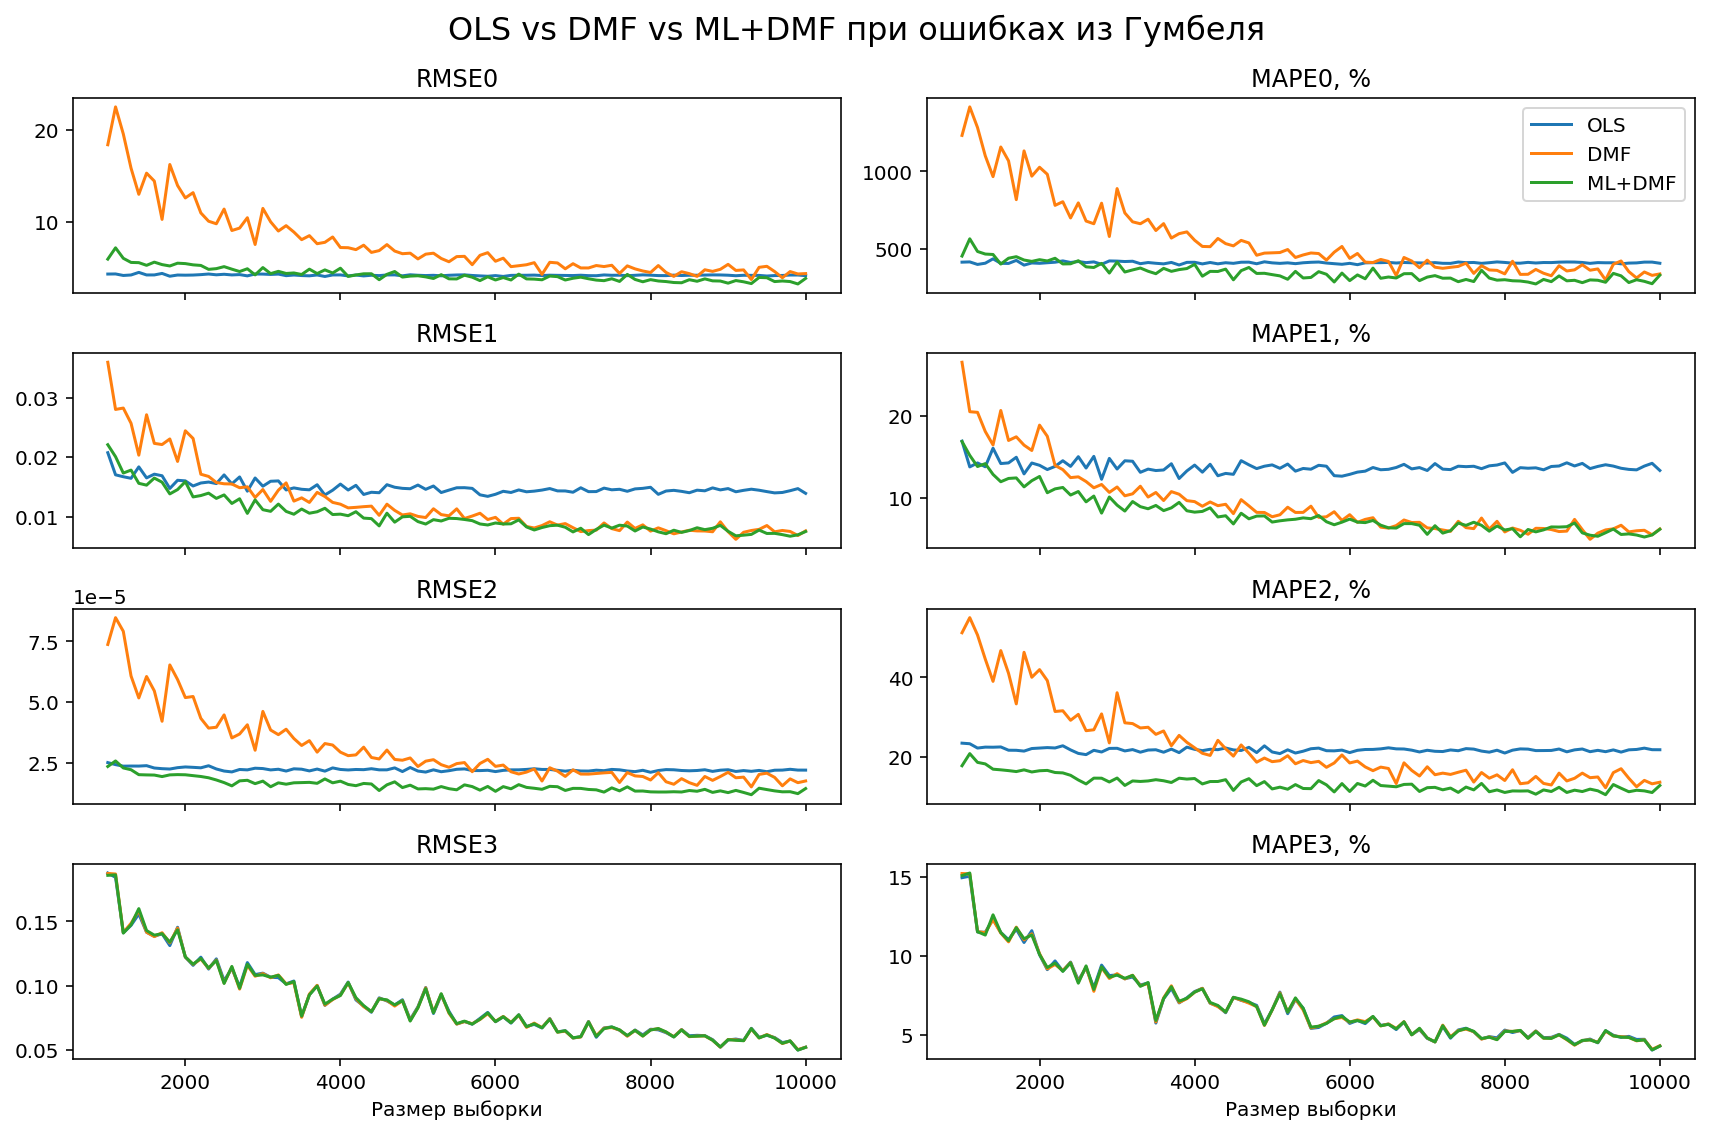

In [90]:
fig, axs = plt.subplots(4, 2, sharex=True)
fig.suptitle("OLS vs DMF vs ML+DMF при ошибках из Гумбеля", fontsize=16)

for i in range(4):
    axs[i, 0].set_title(f"RMSE{i}")
    axs[i, 0].plot(np.array(ols_results)[:, 0], np.array(ols_results)[:, i+1], label='OLS')
    axs[i, 0].plot(np.array(dmf_results)[:, 0], np.array(dmf_results)[:, i+1], label='DMF')
    axs[i, 0].plot(np.array(dmf_results)[:, 0], np.array(ml_results)[:, i+1], label='ML+DMF')

    
for i in range(4):
    axs[i, 1].set_title(f"MAPE{i}, %")
    axs[i, 1].plot(np.array(ols_results)[:, 0], np.array(ols_results)[:, i+5], label='OLS')
    axs[i, 1].plot(np.array(dmf_results)[:, 0], np.array(dmf_results)[:, i+5], label='DMF')
    axs[i, 1].plot(np.array(dmf_results)[:, 0], np.array(ml_results)[:, i+5], label='ML+DMF')
    if not i:
        axs[i, 1].legend()
    
axs[3, 0].set_xlabel('Размер выборки')
axs[3, 1].set_xlabel('Размер выборки')
plt.tight_layout()
plt.savefig('humbel_different_size.pdf', dpi=200);

In [91]:
np.random.seed(999)

n_sizes = np.arange(1000, 10100, 100)
n_simulations = 100
ols_results2 = []
dmf_results2 = []
ml_results2 = []

for n_size in n_sizes:
    ols_coefs, dmf_coefs, ml_coefs, lr_metrics, boost_metrics = simulate3(n_simulations, n_size)
    ols_results2.append(calc_coef_metrics(ols_coefs, beta_spend, model_name=n_size))
    dmf_results2.append(calc_coef_metrics(dmf_coefs, beta_spend, model_name=n_size))
    ml_results2.append(calc_coef_metrics(ml_coefs, beta_spend, model_name=n_size))
    clear_output(wait=True)
    print('Текущий размер выборки (уже посчитан):', n_size)

Текущий размер выборки (уже посчитан): 10000


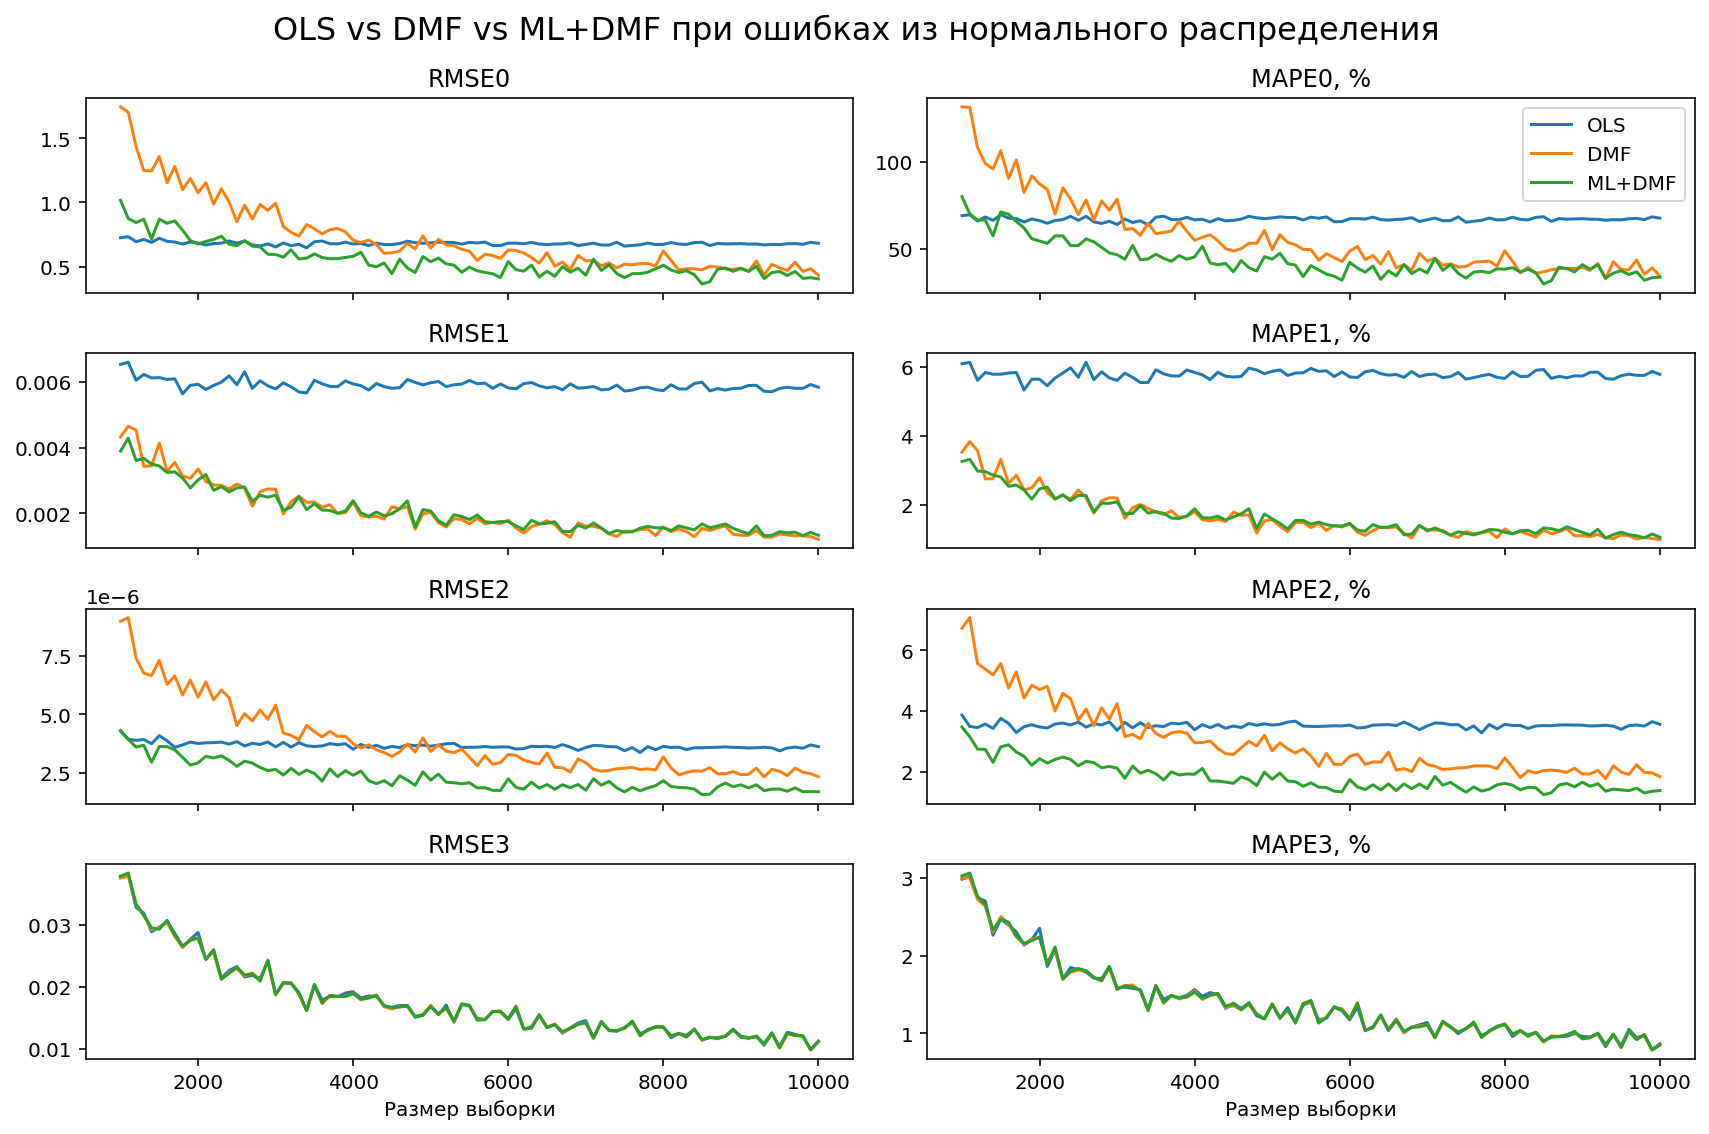

In [92]:
fig, axs = plt.subplots(4, 2, sharex=True)
fig.suptitle("OLS vs DMF vs ML+DMF при ошибках из нормального распределения", fontsize=16)

for i in range(4):
    axs[i, 0].set_title(f"RMSE{i}")
    axs[i, 0].plot(np.array(ols_results2)[:, 0], np.array(ols_results2)[:, i+1], label='OLS')
    axs[i, 0].plot(np.array(dmf_results2)[:, 0], np.array(dmf_results2)[:, i+1], label='DMF')
    axs[i, 0].plot(np.array(dmf_results2)[:, 0], np.array(ml_results2)[:, i+1], label='ML+DMF')

    
for i in range(4):
    axs[i, 1].set_title(f"MAPE{i}, %")
    axs[i, 1].plot(np.array(ols_results2)[:, 0], np.array(ols_results2)[:, i+5], label='OLS')
    axs[i, 1].plot(np.array(dmf_results2)[:, 0], np.array(dmf_results2)[:, i+5], label='DMF')
    axs[i, 1].plot(np.array(dmf_results2)[:, 0], np.array(ml_results2)[:, i+5], label='ML+DMF')
    if not i:
        axs[i, 1].legend()
    
axs[3, 0].set_xlabel('Размер выборки')
axs[3, 1].set_xlabel('Размер выборки')
plt.tight_layout()
plt.savefig('mnorm_different_size.pdf', dpi=200);

### Полиномы (подобранные на кросс-валидации по 10 фолдам)

In [96]:
def simulate7(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    ml_coefs = []
    best_ks = []
    

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample3(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
        ## Полиномы вероятностей
        # Подбираем лучший по LOO-CV (по RMSE)
        ks = np.arange(1, 7)
        all_rmses = []
        for k in ks:
            # генерируем степени вероятностей
            for i in range(1, k+1):
                df[f'proba0^{i}'] = prob_boost[:, 0] ** i
                df[f'proba1^{i}'] = prob_boost[:, 1] ** i
                df[f'proba2^{i}'] = prob_boost[:, 2] ** i
            needed_columns = ['age', 'income', 'drive'] \
                           + [f'proba{category}^{power}' for category in [0, 1, 2] 
                                                         for power in range(1, i)]
            X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
            # считаем RMSE по KFold
            mse_for_k = []
            kf = KFold(n_splits=10)
            for train, test in kf.split(X, y):
                X_train, y_train = X.iloc[train], y.iloc[train]
                X_test, y_test = X.iloc[test], y.iloc[test]
                
                lm = LinearRegression().fit(X_train, y_train)
                mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
            all_rmses.append(np.sqrt(np.mean(mse_for_k)))
        best_k = ks[np.argmin(all_rmses)]
        best_ks.append(best_k)
        
        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
    return ols_coefs, dmf_coefs, ml_coefs, best_ks
        

In [101]:
np.random.seed(999)

n_sizes = np.arange(1000, 10100, 100)
n_simulations = 100
ols_results3 = []
dmf_results3 = []
ml_results3 = []

for n_size in n_sizes:
    ols_coefs, dmf_coefs, ml_coefs, best_ks = simulate7(n_simulations, n_size)
    ols_results3.append(calc_coef_metrics(ols_coefs, beta_spend, model_name=n_size))
    dmf_results3.append(calc_coef_metrics(dmf_coefs, beta_spend, model_name=n_size))
    ml_results3.append(calc_coef_metrics(ml_coefs, beta_spend, model_name=n_size))
    clear_output(wait=True)
    print('Текущий размер выборки (уже посчитан):', n_size)

Текущий размер выборки (уже посчитан): 10000


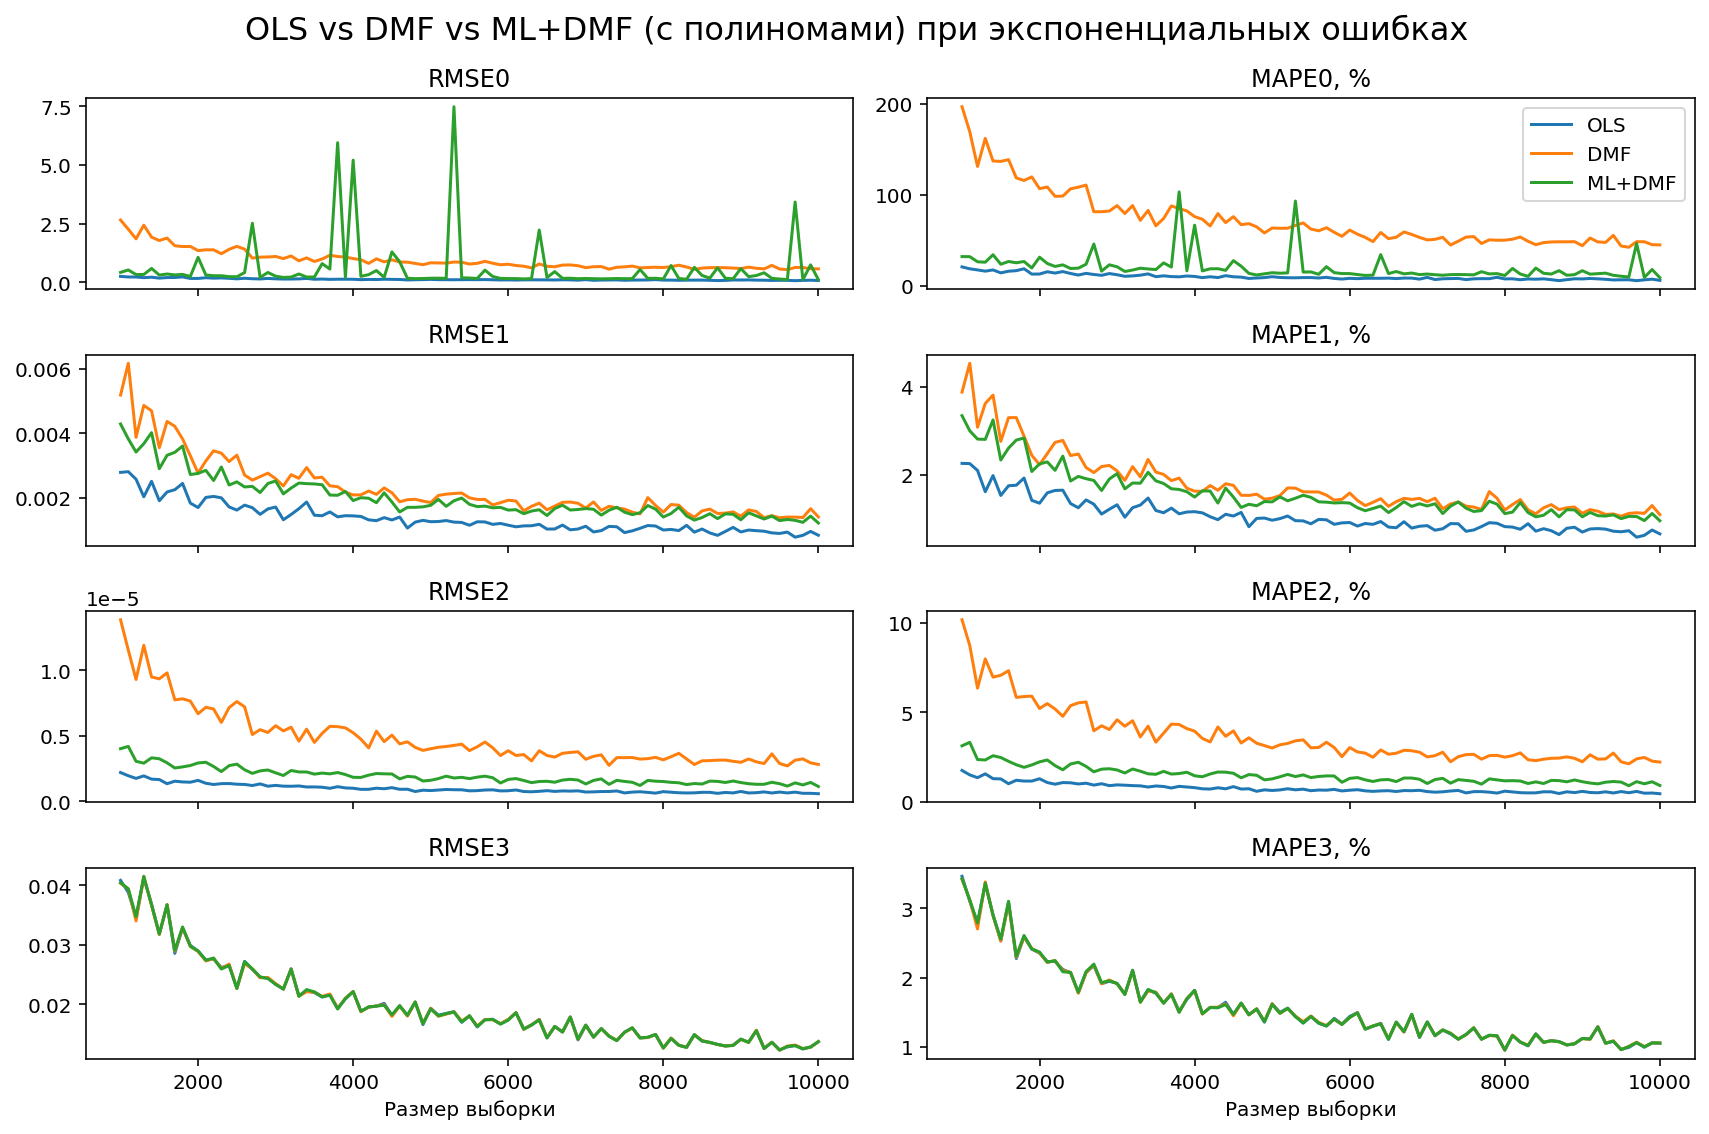

In [118]:
fig, axs = plt.subplots(4, 2, sharex=True)
fig.suptitle("OLS vs DMF vs ML+DMF (с полиномами) при экспоненциальных ошибках", fontsize=16)

for i in range(4):
    axs[i, 0].set_title(f"RMSE{i}")
    axs[i, 0].plot(np.array(ols_results3)[:, 0], np.array(ols_results3)[:, i+1], label='OLS')
    axs[i, 0].plot(np.array(dmf_results3)[:, 0], np.array(dmf_results3)[:, i+1], label='DMF')
    axs[i, 0].plot(np.array(dmf_results3)[:, 0], np.array(ml_results3)[:, i+1], label='ML+DMF')

    
for i in range(4):
    axs[i, 1].set_title(f"MAPE{i}, %")
    axs[i, 1].plot(np.array(ols_results3)[:, 0], np.array(ols_results3)[:, i+5], label='OLS')
    axs[i, 1].plot(np.array(dmf_results3)[:, 0], np.array(dmf_results3)[:, i+5], label='DMF')
    axs[i, 1].plot(np.array(dmf_results3)[:, 0], np.array(ml_results3)[:, i+5], label='ML+DMF')
    if not i:
        axs[i, 1].legend()
    
axs[3, 0].set_xlabel('Размер выборки')
axs[3, 1].set_xlabel('Размер выборки')
plt.tight_layout()
plt.savefig('expon_polynom_different_size.pdf', dpi=200);

### Ошибки из многомерного нормального

In [104]:
def simulate8(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    ml_coefs = []
    best_ks = []
    

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample2(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
        ## Полиномы вероятностей
        # Подбираем лучший по LOO-CV (по RMSE)
        ks = np.arange(1, 7)
        all_rmses = []
        for k in ks:
            # генерируем степени вероятностей
            for i in range(1, k+1):
                df[f'proba0^{i}'] = prob_boost[:, 0] ** i
                df[f'proba1^{i}'] = prob_boost[:, 1] ** i
                df[f'proba2^{i}'] = prob_boost[:, 2] ** i
            needed_columns = ['age', 'income', 'drive'] \
                           + [f'proba{category}^{power}' for category in [0, 1, 2] 
                                                         for power in range(1, i)]
            X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
            # считаем RMSE по KFold
            mse_for_k = []
            kf = KFold(n_splits=10)
            for train, test in kf.split(X, y):
                X_train, y_train = X.iloc[train], y.iloc[train]
                X_test, y_test = X.iloc[test], y.iloc[test]
                
                lm = LinearRegression().fit(X_train, y_train)
                mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
            all_rmses.append(np.sqrt(np.mean(mse_for_k)))
        best_k = ks[np.argmin(all_rmses)]
        best_ks.append(best_k)
        
        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
    return ols_coefs, dmf_coefs, ml_coefs, best_ks
        

In [105]:
np.random.seed(999)

n_sizes = np.arange(1000, 10100, 100)
n_simulations = 100
ols_results4 = []
dmf_results4 = []
ml_results4 = []

for n_size in n_sizes:
    ols_coefs, dmf_coefs, ml_coefs, best_ks = simulate8(n_simulations, n_size)
    ols_results4.append(calc_coef_metrics(ols_coefs, beta_spend, model_name=n_size))
    dmf_results4.append(calc_coef_metrics(dmf_coefs, beta_spend, model_name=n_size))
    ml_results4.append(calc_coef_metrics(ml_coefs, beta_spend, model_name=n_size))
    clear_output(wait=True)
    print('Текущий размер выборки (уже посчитан):', n_size)

Текущий размер выборки (уже посчитан): 10000


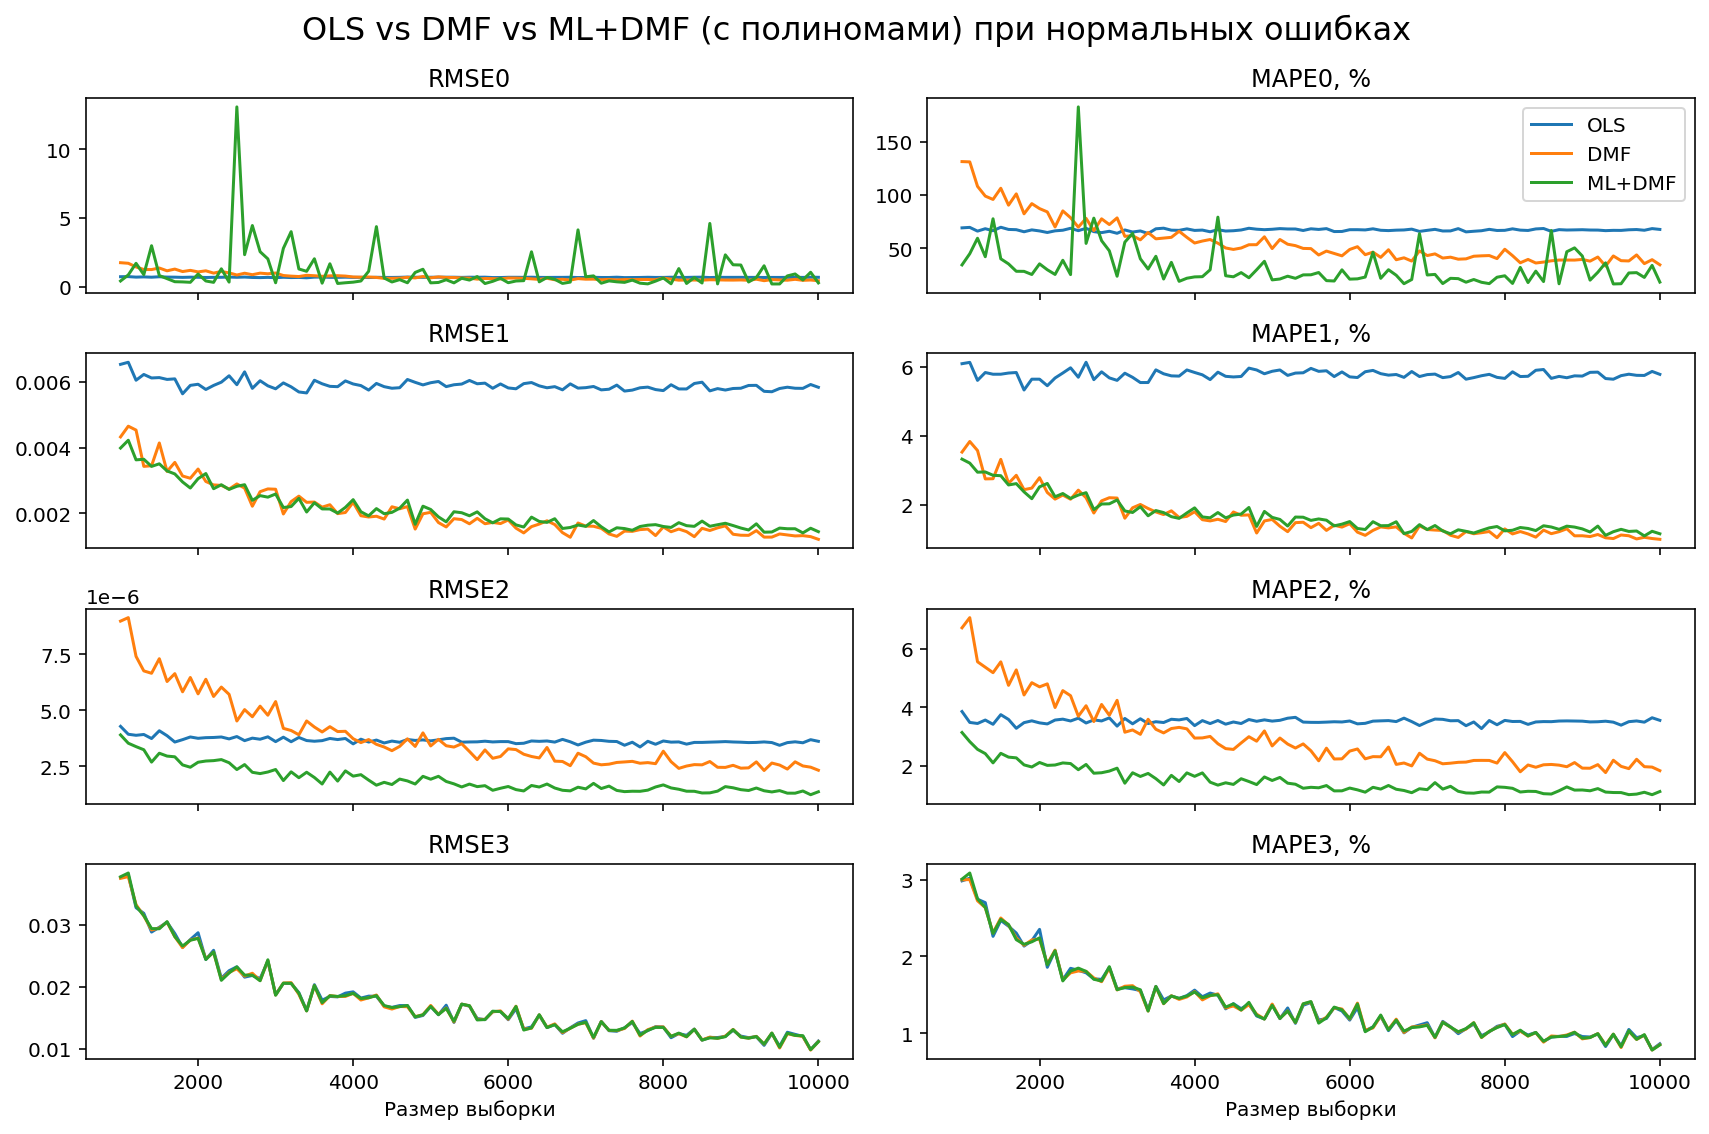

In [111]:
fig, axs = plt.subplots(4, 2, sharex=True)
fig.suptitle("OLS vs DMF vs ML+DMF (с полиномами) при нормальных ошибках", fontsize=16)

for i in range(4):
    axs[i, 0].set_title(f"RMSE{i}")
    axs[i, 0].plot(np.array(ols_results4)[:, 0], np.array(ols_results4)[:, i+1], label='OLS')
    axs[i, 0].plot(np.array(dmf_results4)[:, 0], np.array(dmf_results4)[:, i+1], label='DMF')
    axs[i, 0].plot(np.array(dmf_results4)[:, 0], np.array(ml_results4)[:, i+1], label='ML+DMF')

    
for i in range(4):
    axs[i, 1].set_title(f"MAPE{i}, %")
    axs[i, 1].plot(np.array(ols_results4)[:, 0], np.array(ols_results4)[:, i+5], label='OLS')
    axs[i, 1].plot(np.array(dmf_results4)[:, 0], np.array(dmf_results4)[:, i+5], label='DMF')
    axs[i, 1].plot(np.array(dmf_results4)[:, 0], np.array(ml_results4)[:, i+5], label='ML+DMF')
    if not i:
        axs[i, 1].legend()
    
axs[3, 0].set_xlabel('Размер выборки')
axs[3, 1].set_xlabel('Размер выборки')
plt.tight_layout()
plt.savefig('mnorm_polynom_different_size.pdf', dpi=200);

### Ошибки из Гумбеля

In [112]:
def simulate9(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    ml_coefs = []
    best_ks = []
    

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
        ## Полиномы вероятностей
        # Подбираем лучший по LOO-CV (по RMSE)
        ks = np.arange(1, 7)
        all_rmses = []
        for k in ks:
            # генерируем степени вероятностей
            for i in range(1, k+1):
                df[f'proba0^{i}'] = prob_boost[:, 0] ** i
                df[f'proba1^{i}'] = prob_boost[:, 1] ** i
                df[f'proba2^{i}'] = prob_boost[:, 2] ** i
            needed_columns = ['age', 'income', 'drive'] \
                           + [f'proba{category}^{power}' for category in [0, 1, 2] 
                                                         for power in range(1, i)]
            X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
            # считаем RMSE по KFold
            mse_for_k = []
            kf = KFold(n_splits=10)
            for train, test in kf.split(X, y):
                X_train, y_train = X.iloc[train], y.iloc[train]
                X_test, y_test = X.iloc[test], y.iloc[test]
                
                lm = LinearRegression().fit(X_train, y_train)
                mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
            all_rmses.append(np.sqrt(np.mean(mse_for_k)))
        best_k = ks[np.argmin(all_rmses)]
        best_ks.append(best_k)
        
        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
    return ols_coefs, dmf_coefs, ml_coefs, best_ks
        

In [113]:
np.random.seed(999)

n_sizes = np.arange(1000, 10100, 100)
n_simulations = 100
ols_results5 = []
dmf_results5 = []
ml_results5 = []

for n_size in n_sizes:
    ols_coefs, dmf_coefs, ml_coefs, best_ks = simulate9(n_simulations, n_size)
    ols_results5.append(calc_coef_metrics(ols_coefs, beta_spend, model_name=n_size))
    dmf_results5.append(calc_coef_metrics(dmf_coefs, beta_spend, model_name=n_size))
    ml_results5.append(calc_coef_metrics(ml_coefs, beta_spend, model_name=n_size))
    clear_output(wait=True)
    print('Текущий размер выборки (уже посчитан):', n_size)

Текущий размер выборки (уже посчитан): 10000


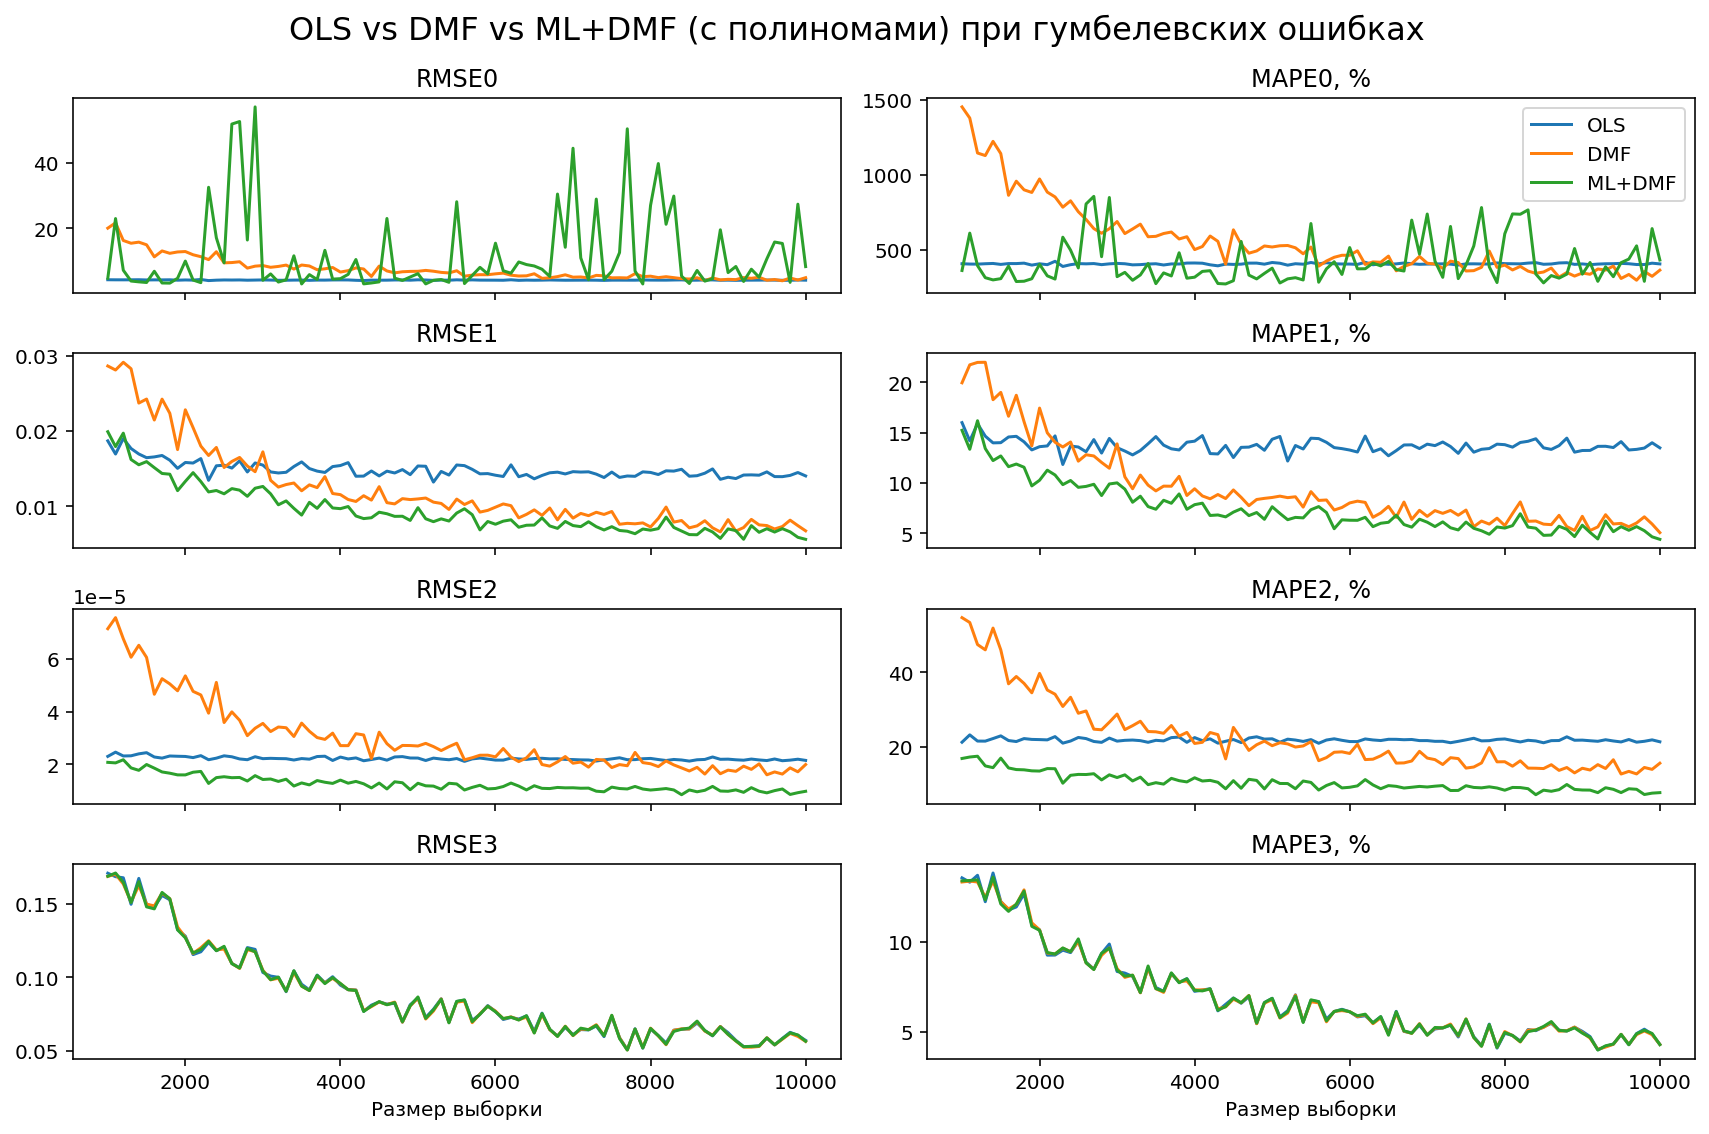

In [117]:
fig, axs = plt.subplots(4, 2, sharex=True)
fig.suptitle("OLS vs DMF vs ML+DMF (с полиномами) при гумбелевских ошибках", fontsize=16)

for i in range(4):
    axs[i, 0].set_title(f"RMSE{i}")
    axs[i, 0].plot(np.array(ols_results5)[:, 0], np.array(ols_results5)[:, i+1], label='OLS')
    axs[i, 0].plot(np.array(dmf_results5)[:, 0], np.array(dmf_results5)[:, i+1], label='DMF')
    axs[i, 0].plot(np.array(dmf_results5)[:, 0], np.array(ml_results5)[:, i+1], label='ML+DMF')

    
for i in range(4):
    axs[i, 1].set_title(f"MAPE{i}, %")
    axs[i, 1].plot(np.array(ols_results5)[:, 0], np.array(ols_results5)[:, i+5], label='OLS')
    axs[i, 1].plot(np.array(dmf_results5)[:, 0], np.array(dmf_results5)[:, i+5], label='DMF')
    axs[i, 1].plot(np.array(dmf_results5)[:, 0], np.array(ml_results5)[:, i+5], label='ML+DMF')
    if not i:
        axs[i, 1].legend()
    
axs[3, 0].set_xlabel('Размер выборки')
axs[3, 1].set_xlabel('Размер выборки')
plt.tight_layout()
plt.savefig('humbel_polynom_different_size.pdf', dpi=200);